# Isotopically non-stationary 13C-MFA

In [45]:
import pandas as pd
import numpy as np
import dotenv
import ast
import pandera as pa
import incawrapper
from incawrapper import utils
import pathlib


In [46]:
# import environment variables
INCA_base_directory = dotenv.get_key(dotenv.find_dotenv(), "INCA_base_directory")
data_dir = pathlib.Path('./Literature data/Astrocytes and neural stem cells/')
data_dir.exists()

True

First, we will load and process the reactions data. We will start by refreshing the requirements for the dataframe. 

In [47]:
utils.present_schema_overview(incawrapper.ReactionsSchema)

,column name,dtype,required,nullable,description
0,rxn_id,str,True,False,The unique id of the reaction
1,rxn_eqn,str,True,False,"The reaction equation with atom map. Allowed reaction arrows: ->, <->."


We will now read in the data and rename the column to fit the requirements from `ReactionsSchema`.

In [48]:
xl = pd.ExcelFile(data_dir / 'Model.xlsx')
reactions = (xl.parse('Sheet1')
    .rename(columns={'Reaction ID': 'rxn_id', 'Equations (Carbon atom transition)': 'rxn_eqn'})
)
reactions.head()

,rxn_id,rxn_eqn
0,R1,G6P (abcdef) <-> F6P (abcdef)
1,R2,F6P (abcdef) -> FBP (abcdef)
2,R3,FBP (abcdef) <-> DHAP (cba) + GAP (def)
3,R4,DHAP (abc) <-> GAP (abc)
4,R5,GAP (abc) <-> 3PG (abc)


We are now ready to validate the data. This is easiest done if the validation is wrapped in the try-except statement, because will produce a much nicer output in case the validation does not pass.

In [49]:
try:
    incawrapper.ReactionsSchema.validate(reactions)
except pa.schemas.errors.SchemaError as e:
    print(type(e))
    print(e)

The data passes the validation and we can move on to measurements of the exchange fluxes.

In [50]:
utils.present_schema_overview(incawrapper.FluxMeasurementsSchema)

,column name,dtype,required,nullable,description
0,experiment_id,str,True,False,"ID of the experiment. Must be a valid MATLAB variable name, legal characters are a-z, A-Z, 0-9, and the underscore character."
1,rxn_id,str,True,False,The unique id of the reaction
2,flux,float64,True,False,Measured/estimated rate typically in mmol/gDW/h
3,flux_std_error,float64,True,False,Standard error of the measured/estimated rate


In [51]:
flux_measurements_raw = pd.read_csv(data_dir / 'exchange_fluxes.csv')
flux_measurements_raw.head()

,Metabolite,Neural Stem Cells,Astrocytes
0,Glucose,-256.3 ± 1.3,-175.7 ± 17.9
1,Lactate,237.8 ± 10.1,348.6 ± 9.6
2,Aspartate,-2.6 ± 0.7,-11.9 ± 5.8
3,Glutamate,-1.8 ± 0.4,-10.5 ± 3.4
4,Serine,-2.8 ± 1.4,-4.1 ± 1.7


In [52]:
flux_measurements = (flux_measurements_raw
    .melt(id_vars=['Metabolite'], value_vars=['Astrocytes', 'Neural Stem Cells'], var_name='Cell type', value_name='flux')
    .replace({'flux': {'nan': np.nan}})
)

flux_measurements[['flux', 'flux_std_error']] = flux_measurements['flux'].str.split('±', expand=True).astype(float)
flux_measurements['experiment_id'] = flux_measurements['Cell type'].str.replace(' ', '_')
flux_measurements.head()

,Metabolite,Cell type,flux,flux_std_error,experiment_id
0,Glucose,Astrocytes,-175.7,17.9,Astrocytes
1,Lactate,Astrocytes,348.6,9.6,Astrocytes
2,Aspartate,Astrocytes,-11.9,5.8,Astrocytes
3,Glutamate,Astrocytes,-10.5,3.4,Astrocytes
4,Serine,Astrocytes,-4.1,1.7,Astrocytes


The raw data uses the metabolite to reference which the exchange reactions. The INCA Parse require the reaction id (`rxn_id`) to attach a flux measurement to a reaction. Next, we make a map from metabolite to `rxn_id`.

In [53]:
exchange_reactions_metabolite_map = {
    'CO2': 'R44',
    'Glucose': 'R45',
    'Lactate': 'R46',
    'Alanine': 'R47',
    'Pyruvate': 'R48',
    'Citrate': 'R49',
    'Glutamine': 'R50',
    'Glutamate': 'R51',
    'Aspartate': 'R52',
    'Asparagine': 'R53',
    'Serine': 'R54',
    'Glycine': 'R55',
    'Proline': 'R56',
    'Valine': 'R57',
    'Isoleucine': 'R58',
    'Leucine': 'R59',
    'Threonine': 'R60',
    'Phenylalanine': 'R61',
    'Tyrosine': 'R62',
    'Methionine': 'R63',
    'Lysine': 'R64',
    'Histidine': 'R65',
    'Arginine': 'R66',
}

We can use this map to create a new colum with the reaction ids.

In [54]:
flux_measurements['rxn_id'] = flux_measurements['Metabolite'].map(exchange_reactions_metabolite_map)
flux_measurements.head()

,Metabolite,Cell type,flux,flux_std_error,experiment_id,rxn_id
0,Glucose,Astrocytes,-175.7,17.9,Astrocytes,R45
1,Lactate,Astrocytes,348.6,9.6,Astrocytes,R46
2,Aspartate,Astrocytes,-11.9,5.8,Astrocytes,R52
3,Glutamate,Astrocytes,-10.5,3.4,Astrocytes,R51
4,Serine,Astrocytes,-4.1,1.7,Astrocytes,R54


In [55]:
# The glucose exchange reactions are recorded in the opposite direction than in the model
# thus the direction is now inversed
flux_measurements.loc[flux_measurements['rxn_id'] == 'R45', 'flux'] = flux_measurements.loc[flux_measurements['rxn_id'] == 'R45', 'flux'].abs()

In [56]:
try:
    incawrapper.FluxMeasurementsSchema.validate(flux_measurements)
except pa.schemas.errors.SchemaError as e:
    print(type(e))
    print(e)

<class 'pandera.errors.SchemaError'>
non-nullable series 'flux' contains null values:
6    NaN
12   NaN
13   NaN
14   NaN
17   NaN
29   NaN
30   NaN
31   NaN
39   NaN
40   NaN
Name: flux, dtype: float64


Ups, the validation failed because the incawrapper does not allow null values in the measured fluxes. In the supplementary documentation the authors write: "NaN represents undetermined transport rates". We interpret as these rate were not measured, thus we don't know anything about the rate and it could take any value. Therefore, we will simply remove the measurements with NaN. 

An alternative interpretation is that the rate were measured but the value was below the detection limits. In that case the NaNs should be replaced by small numbers. 

In [57]:
# flux_measurements['flux'] = flux_measurements['flux'].fillna(0)
# flux_measurements['flux_std_error'] = flux_measurements['flux_std_error'].fillna(1e-4)
flux_measurements.dropna(subset=['flux'], inplace=True)

try:
    incawrapper.FluxMeasurementsSchema.validate(flux_measurements)
except pa.schemas.errors.SchemaError as e:
    print(type(e))
    print(e)

Now, the flux measurements dataframe passes the validation and we can import the MS measurements.

In [58]:
ms_measurements_raw = pd.read_csv(data_dir / 'MDVs.csv')
ms_measurements_raw.head()

,Unnamed: 0,N_0.33 h,N_3 h,N_12 h,N_24 h,A_0.33 h,A_3 h,A_12 h,A_24 h
0,3PG (M0),0.639,0.787,0.604,0.564,0.586,0.568,0.667,0.582
1,3PG (M1),0.361,0.213,0.396,0.436,0.414,0.432,0.333,0.418
2,PEP (M0),0.695,0.771,0.618,0.578,0.608,0.639,0.754,0.674
3,PEP (M1),0.305,0.229,0.382,0.422,0.392,0.361,0.246,0.326
4,Lac (M0),0.906,0.882,0.891,0.844,0.992,0.986,0.968,0.824


We see that the header contains information about the the cell type and the sampling time. We will start by processing the data into tidy format.

In [59]:
ms_measurements = (ms_measurements_raw
    .melt(id_vars=['Unnamed: 0'], var_name=['cell_time'], value_name='intensity')
)
ms_measurements[['cell_type', 'time']] = ms_measurements['cell_time'].str.split('_', expand=True)

ms_measurements['experiment_id'] = ms_measurements['cell_type'].map({'N': 'Neural_Stem_Cells', 'A': 'Astrocytes'})
ms_measurements['time'] = ms_measurements['time'].str.replace(' h', '').astype(float)
ms_measurements[['met_id', 'mass_isotope']] = ms_measurements['Unnamed: 0'].str.split(' ', expand=True)
ms_measurements['ms_id'] = ms_measurements['met_id']
ms_measurements['mass_isotope'] = ms_measurements['mass_isotope'].str.extract('(\d+)').astype(int)
ms_measurements['measurement_replicate'] = 1
ms_measurements.head()

,Unnamed: 0,cell_time,intensity,cell_type,time,experiment_id,met_id,mass_isotope,ms_id,measurement_replicate
0,3PG (M0),N_0.33 h,0.639,N,0.33,Neural_Stem_Cells,3PG,0,3PG,1
1,3PG (M1),N_0.33 h,0.361,N,0.33,Neural_Stem_Cells,3PG,1,3PG,1
2,PEP (M0),N_0.33 h,0.695,N,0.33,Neural_Stem_Cells,PEP,0,PEP,1
3,PEP (M1),N_0.33 h,0.305,N,0.33,Neural_Stem_Cells,PEP,1,PEP,1
4,Lac (M0),N_0.33 h,0.906,N,0.33,Neural_Stem_Cells,Lac,0,Lac,1


In [60]:
ms_measurements['met_id'].unique()

array(['3PG', 'PEP', 'Lac', 'Ala', 'Cit', 'Suc', 'Fum', 'Mal', 'Asp',
       'Glu', 'Gln'], dtype=object)

In [61]:
molecular_formulars = {
    'PEP': 'C3H2O6P',
    '3PG': 'C3H4O7P',
    'Lac': 'C3H5O3',
    'Ala': 'C3H7NO2',
    'Cit': 'C6H5O7',
    'Suc': 'C4H4O4',
    'Fum': 'C4H2O4',
    'Mal': 'C4H4O5',
    'Asp': 'C4H6NO4',
    'Glu': 'C5H8NO4',
    'Gln': 'C5H10N2O3'
}

In [62]:
ms_measurements['unlabelled_atoms'] = ms_measurements['met_id'].map(molecular_formulars).str.replace(r'(C\d+)','', regex=True)
ms_measurements

,Unnamed: 0,cell_time,intensity,cell_type,time,experiment_id,met_id,mass_isotope,ms_id,measurement_replicate,unlabelled_atoms
0,3PG (M0),N_0.33 h,0.639,N,0.33,Neural_Stem_Cells,3PG,0,3PG,1,H4O7P
1,3PG (M1),N_0.33 h,0.361,N,0.33,Neural_Stem_Cells,3PG,1,3PG,1,H4O7P
2,PEP (M0),N_0.33 h,0.695,N,0.33,Neural_Stem_Cells,PEP,0,PEP,1,H2O6P
3,PEP (M1),N_0.33 h,0.305,N,0.33,Neural_Stem_Cells,PEP,1,PEP,1,H2O6P
4,Lac (M0),N_0.33 h,0.906,N,0.33,Neural_Stem_Cells,Lac,0,Lac,1,H5O3
...,...,...,...,...,...,...,...,...,...,...,...
299,Glu (M3),A_24 h,0.001,A,24.00,Astrocytes,Glu,3,Glu,1,H8NO4
300,Gln (M0),A_24 h,0.716,A,24.00,Astrocytes,Gln,0,Gln,1,H10N2O3
301,Gln (M1),A_24 h,0.240,A,24.00,Astrocytes,Gln,1,Gln,1,H10N2O3
302,Gln (M2),A_24 h,0.043,A,24.00,Astrocytes,Gln,2,Gln,1,H10N2O3


In [63]:
def create_labelled_atoms_list(molecular_formular):
    """Return a list of length equal to the number of carbon atoms. Assumes that C is the first element in the molecular formular."""
    carbon_atoms = int(molecular_formular[1])
    return list(range(1, carbon_atoms + 1))

ms_measurements['labelled_atom_ids'] = ms_measurements['met_id'].map(molecular_formulars).map(create_labelled_atoms_list)

In the supplementary content the authors state that they used a 1.5mol% error for the ms measurements. We will set the measurement error here.

In [64]:
ms_measurement_error = 0.015 # 1.5mol% error
ms_measurements['intensity_std_error'] = ms_measurement_error

In [65]:
# dropping unnecessary columns and rearrange order of columns
ms_measurements = ms_measurements[[
    'experiment_id', 'met_id', 'ms_id', 'time', 'labelled_atom_ids', 'unlabelled_atoms', 'measurement_replicate' ,
    'mass_isotope', 'intensity', 'intensity_std_error'
]]

In [66]:
try:
    incawrapper.MSMeasurementsSchema.validate(ms_measurements)
except pa.schemas.errors.SchemaError as e:
    print(type(e))
    print(e)

Finally, we need to specify what tracers were used in the experiment. For both Neural stems cells and Astrocytes, they use [1-13C]Glucose as the labelled substrate.

In [67]:
tracers = pd.DataFrame({
    'experiment_id': ['Astrocytes', 'Neural_Stem_Cells'],
    'tracer_id': ['[1-13C]Glucose', '[1-13C]Glucose'],
    'met_id': ['Glc.ext', 'Glc.ext'],
    'atom_ids': [[1], [1]],
    'atom_mdv' : [[0.01, 0.99], [0.01, 0.99]],
    'enrichment': [1, 1],
})


In [68]:
use_experiment_ids = ['Neural_Stem_Cells']
output_file = data_dir / f'{"_".join(use_experiment_ids)}_estimation.mat'

In [69]:
inca_script = incawrapper.create_inca_script_from_data(
    reactions_data=reactions,
    tracer_data=tracers,
    flux_measurements=flux_measurements,
    ms_measurements=ms_measurements,
    experiment_ids=use_experiment_ids
)
inca_script.add_to_block("options", incawrapper.define_options(sim_na=False, sim_ss=False, sim_more=False, fit_starts=2))
inca_script.add_to_block("runner", incawrapper.define_runner(output_filename=output_file, run_estimate=True, run_simulation=True))

In [70]:
unbalanced_metabolites = ["AcCoA.c", "Ala.ext", "Arg.ext", "Asn.ext", "Asp.ext", "CO2.ext", "Cit.ext", "Cys.snk", "Gln.ext", "Glu.ext", "Glc.ext", "Gly.ext", "His.ext", "Ile.ext", "Lac.ext", "Leu.ext", "Lys.ext", "Met.ext", "Phe.ext", "Pro.ext", "Pyr.ext", "Ser.ext", "Thr.ext", "Tyr.ext", "Urea.snk", "Val.ext"]
unbalanced_str = ""
for met in unbalanced_metabolites:
    unbalanced_str += incawrapper.modify_class_instance("states", None, instance_id=met, properties={"bal":False})
inca_script.add_to_block("model", unbalanced_str)

In [38]:
print(inca_script)

clear functions

% REACTION BLOCK
% Create reactions
r = [...
reaction('G6P (abcdef) <-> F6P (abcdef)', 'id', 'R1'),...
reaction('F6P (abcdef) -> FBP (abcdef)', 'id', 'R2'),...
reaction('FBP (abcdef) <-> DHAP (cba) + GAP (def)', 'id', 'R3'),...
reaction('DHAP (abc) <-> GAP (abc)', 'id', 'R4'),...
reaction('GAP (abc) <-> 3PG (abc)', 'id', 'R5'),...
reaction('3PG (abc) <-> PEP (abc)', 'id', 'R6'),...
reaction('PEP (abc) -> Pyr.c (abc)', 'id', 'R7'),...
reaction('G6P (abcdef) -> P5P (bcdef) + CO2 (a)', 'id', 'R8'),...
reaction('P5P (abcde) + P5P (pqrst) <-> GAP (rst) + S7P (pqabcde)', 'id', 'R9'),...
reaction('S7P (abcdefg) + GAP (xyz) <-> E4P (defg) + F6P (abcxyz)', 'id', 'R10'),...
reaction('E4P (abcd) + P5P (pqrst) <-> GAP (rst) + F6P (pqabcd)', 'id', 'R11'),...
reaction('Pyr.c (abc) <-> Lac (abc)', 'id', 'R12'),...
reaction('Pyr.c (abc) <-> Ala (abc)', 'id', 'R13'),...
reaction('Pyr.m (abc) -> AcCoA.m (bc) + CO2 (a)', 'id', 'R14'),...
reaction('Pyr.m (abc) + CO2 (d) -> OAC (abcd)', 'i

In [39]:
incawrapper.run_inca(inca_script, INCA_base_directory=INCA_base_directory)

INCA script saved to /var/folders/z6/mxpxh4k56tv0h0ff41vmx7gdwtlpvp/T/tmpwu_mnnw1/inca_script.m.
Starting MATLAB engine...
 
ms_Neural_Stem_Cells = 1x11 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
3PG Ala Asp Cit Fum Gln Glu Lac Mal PEP Suc
 
 
ms_Neural_Stem_Cells = 1x11 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
3PG Ala Asp Cit Fum Gln Glu Lac Mal PEP Suc
 
 
ms_Neural_Stem_Cells = 1x11 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
3PG Ala Asp Cit Fum Gln Glu Lac Mal PEP Suc
 
 
ms_Neural_Stem_Cells = 1x11 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
3PG Ala Asp Cit Fum Gln Glu Lac Mal PEP Suc
 
 
ms_Neural_Stem_Cells = 1x11 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
3PG Ala Asp Cit Fum Gln Glu Lac Mal PEP Suc
 
 
ms_Neural_Stem_Cells = 1x11 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
3PG Ala Asp Cit Fum Gln Glu Lac Mal PEP Suc
 
 
ms_Neural_Stem_Cells = 1x11 msdata object

In [71]:
res_astro = incawrapper.INCAResults("./Literature data/Astrocytes and neural stem cells/astrocytes_estimation.mat")
res_astro.fitdata.get_goodness_of_fit()

Fit accepted: False
Confidence level: 0.05
Chi-square value (SSR): 16005.825451990784
Expected chi-square range: [12.40115022 39.36407703]


In [72]:
res = incawrapper.INCAResults(output_file)

First we will check the goodness of the fit using the build in method.

In [73]:
res.fitdata.get_goodness_of_fit()

Fit accepted: False
Confidence level: 0.05
Chi-square value (SSR): 485.4942377929357
Expected chi-square range: [12.40115022 39.36407703]


We see that the fit for the neural stem cells data is not accepted because the summed squared residuals (SSR) is not with the expected range. Actually, it is quite far from a factor 10 above the upper bound. This does not align with the SSR stated in paper. We can further expect the results to try to narrow what we might have done differently when setting up the model. 

We will start by investigating the degree of freedom. In the supplementary content the authors state that the degrees of freedom in their models was 73 and 83 for the Astrocytes and NSC model respectively.

In [74]:
res.fitdata.degrees_of_freedom

24

The difference indicate that we did not manage to setup the model and measurements as the authors of the paper. We have fewer degrees of freedom, which can result from either fewer measurements or more independent parameters (fluxes, pool sizes etc.) to estimate in our model.

In [75]:
from incawrapper import visualization 
visualization.plot_norm_prob(res, interactive=True)

/Users/s143838/.virtualenvs/bfair-testing/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [76]:
res.fitdata.fitted_parameters.query("id.isin(['R1 net', 'R45'])")

,type,id,eqn,val,std,lb,ub,unit,free,alf,chi2s,cont,cor,cov,vals,base
0,Net flux,R1 net,G6P <-> F6P,139.033645,442.941021,[],[],[],0,0.05,[],1,"[0.9999999999999997, -0.0057127416639321995, 0...","[196196.74837095028, -195833.83032978995, 6539...",[],{'id': []}
67,Net flux,R45,Glc.ext -> G6P,256.300765,1.300000,[],[],[],0,0.05,[],1,"[-0.014674293239171618, 8.380401043134567e-05,...","[-8.449800337755237, 8.431510468884504, -1.689...",[],{'id': []}


In [77]:
res.model.states.query("bal == 0")

,bal,fix,id,lb,met,opt,phase,type,ub,unit,val,base
2,0,0,AcCoA.c,0,AcCoA,1,c,snk,inf,[],1,{'id': []}
5,0,0,Ala.ext,0,Ala,1,ext,int,inf,[],1,{'id': []}
7,0,0,Arg.ext,0,Arg,1,ext,int,inf,[],1,{'id': []}
9,0,0,Asn.ext,0,Asn,1,ext,int,inf,[],1,{'id': []}
11,0,0,Asp.ext,0,Asp,1,ext,int,inf,[],1,{'id': []}
14,0,0,CO2.ext,0,CO2,1,ext,int,inf,[],1,{'id': []}
16,0,0,Cit.ext,0,Cit,1,ext,snk,inf,[],1,{'id': []}
17,0,0,Cys.snk,0,Cys,1,snk,snk,inf,[],1,{'id': []}
25,0,0,Glc.ext,0,Glc,1,ext,src,inf,[],1,{'id': []}
27,0,0,Gln.ext,0,Gln,1,ext,int,inf,[],1,{'id': []}


In [78]:
res.fitdata.fitted_parameters.query('free == 1')['type'].value_counts()

Norm         44
Pool         41
Exch flux    34
Net flux     25
Name: type, dtype: int64

In [86]:
res.fitdata.fitted_parameters.query("type == 'Norm'")['val'].describe()

count    44.000000
mean      0.998520
std       0.022667
min       0.954017
25%       0.983727
50%       0.999005
75%       1.006709
max       1.077917
Name: val, dtype: float64

In [80]:
res.fitdata.fitted_parameters.query("id.str.contains('R46')")

,type,id,eqn,val,std,lb,ub,unit,free,alf,chi2s,cont,cor,cov,vals,base
68,Net flux,R46 net,Lac <-> Lac.ext,237.777183,10.099998,[],[],[],0,0.05,[],1,"[0.0684375961282787, -0.00039086293395119656, ...","[306.16952141751756, -305.5223769714597, 102.0...",[],{'id': []}
69,Exch flux,R46 exch,Lac <-> Lac.ext,323.123336,37.950955,[],[],[],1,0.05,[],1,"[0.13146723322464818, -0.0007502294467658314, ...","[2209.968786383081, -2203.505052682797, 736.65...",[],{'id': []}


<AxesSubplot: xlabel='std', ylabel='weighted residual'>

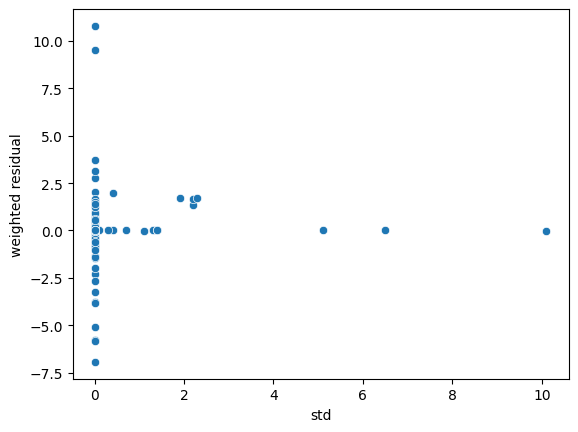

In [81]:
import seaborn as sns
sns.scatterplot(
    data=res.fitdata.measurements_and_fit_detailed,
    x='std',
    y='weighted residual'
)

In [82]:
res.fitdata.measurements_and_fit_detailed['std'].describe()

count    168.000000
mean       0.236192
std        1.058872
min        0.014985
25%        0.015000
50%        0.015000
75%        0.015015
max       10.100000
Name: std, dtype: float64